In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pickle
import sys
from skimage import io
import os

sys.path.append("../../")


%load_ext autoreload
%autoreload 2
%matplotlib inline

## Input Directory

In [6]:
from dataprocessing.dataloaders import ImageBlindSpotDataset

## This should be the file where the .npz data is:: !!!
data_dir = '/home/natalia/ImPartial/Data/MIBI_2CH/' ## This should be the file where the .npz data is

pd_files = pd.read_csv(data_dir+'files.csv',index_col=0)

## !!! Uncoment the following if 'input_dir' in files.csv does not match data_dir
pd_files['input_dir'] = data_dir
pd_files.to_csv(data_dir + 'files.csv')

print(pd_files)

scribbles = '150'
files_scribbles = data_dir + 'files_2tasks1x2classes_3images_scribble_train_' + scribbles + '.csv'
pd_files_scribbles = pd.read_csv(files_scribbles)

## !!! Uncoment the following if 'input_dir' in pd_files_scribbles does not match data_dir
pd_files_scribbles['input_dir'] = data_dir
pd_files_scribbles.to_csv(files_scribbles,index=None)

print()
print('Total images  train: ', len(pd_files_scribbles),'; test: ', len(pd_files)-len(pd_files_scribbles) )
pd_files_scribbles

   prefix                               input_dir  input_file  group
0  image0  /home/natalia/ImPartial/Data/MIBI_2CH/  image0.npz  train
1  image1  /home/natalia/ImPartial/Data/MIBI_2CH/  image1.npz  train
2  image2  /home/natalia/ImPartial/Data/MIBI_2CH/  image2.npz   test
3  image3  /home/natalia/ImPartial/Data/MIBI_2CH/  image3.npz  train

Total images  train:  3 ; test:  1


,input_dir,input_file,prefix,scribble_file,total_labels_class0,scribble_labels_class0,label_with_scribble_class0,perc_pixels_scribbles_TP_class0,perc_pixels_scribbles_TN_class0,total_labels_class1,...,label_with_scribble_class1,perc_pixels_scribbles_TP_class1,perc_pixels_scribbles_TN_class1,total_labels_class2,scribble_labels_class2,label_with_scribble_class2,perc_pixels_scribbles_TP_class2,perc_pixels_scribbles_TN_class2,gt_index_task0,gt_index_task1
0,/home/natalia/ImPartial/Data/MIBI_2CH/,image0.npz,image0,image0_2tasks1x2classes_3images_scribble_n150.npz,160,23,[ 1 5 6 9 10 13 20 26 27 34 41 ...,2.14,3.87,152,...,[ 3 5 16 19 34 36 37 49 55 62 63 ...,0.42,0.92,20,12,[ 1 3 5 6 8 9 13 14 15 16 17 18],6.01,0.49,[0],"[1, 2]"
1,/home/natalia/ImPartial/Data/MIBI_2CH/,image1.npz,image1,image1_2tasks1x2classes_3images_scribble_n150.npz,72,20,[ 2 3 4 14 16 18 21 24 29 37 48 54 60 63 67 ...,4.24,1.86,61,...,[ 4 7 10 15 16 18 20 23 26 29 30 31 47 48 54 ...,0.70,1.03,49,11,[ 3 5 6 8 13 14 25 45 46 48 49],1.49,0.46,[0],"[1, 2]"
2,/home/natalia/ImPartial/Data/MIBI_2CH/,image3.npz,image3,image3_2tasks1x2classes_3images_scribble_n150.npz,62,22,[ 1 8 12 18 23 24 25 26 27 28 29 31 44 48 49 ...,7.12,2.16,47,...,[ 9 10 11 12 14 15 17 23 26 28 30 31 33 34 36 41],1.28,0.80,122,14,[24 26 27 29 32 49 51 52 53 54 55 56 59 65],0.44,0.71,[0],"[1, 2]"


## Load Trained Model

In [8]:
from general.utils import mkdir,load_json
basedir = '/data/natalia/models/Impartial/'
model_name = 'MIBI2CH_test'
GPU_ID = 0

config_json = load_json(basedir+model_name+'/config.json')

from Impartial.Impartial_classes import ImPartialConfig
config = ImPartialConfig(config_dic=config_json,GPU_ID=GPU_ID)

from Impartial.Impartial_classes import ImPartialModel
im_model = ImPartialModel(config)

---------------- Impartial model config created ----------------------------

Model directory: /data/natalia/models/Impartial/MIBI2CH_test/

-- Config file :
ImPartialConfig(BATCH_SIZE=64, DEVICE=device(type='cuda', index=0), EPOCHS=400, GPU_ID=0, LEARNING_RATE=0.0005, activation='relu', augmentations=True, basedir='/data/natalia/models/Impartial/', batchnorm=False, best_model='weights_best.pth', classification_tasks={'0': {'classes': 1, 'rec_channels': [0], 'ncomponents': [2, 2], 'weight_classes': [1.0], 'weight_rec_channels': [1.0], 'ix_gt_labels': ['0']}, '1': {'classes': 2, 'rec_channels': [1], 'ncomponents': [1, 1, 2], 'weight_classes': [0.5, 0.5], 'weight_rec_channels': [1.0], 'ix_gt_labels': ['1', ' 2']}}, last_model='weights_last.pth', lrdecay=1, max_grad_clip=0, mean=True, model_name='MIBI2CH_test', n_channels=2, n_output=16, n_workers=32, nepochs_sample_patches=10, normstd=False, npatch_image_sampler=1365, npatches_epoch=4096, nsaves=5, optim_weight_decay=0.0, optimizer='adam

## Evaluation

In [9]:
output_list,gt_list = im_model.eval(pd_files)

Evaluating average predictions of models : 
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save0.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save1.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save2.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save3.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save4.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save0.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save1.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save2.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save3.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save4.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image0.npz train
Task :  0


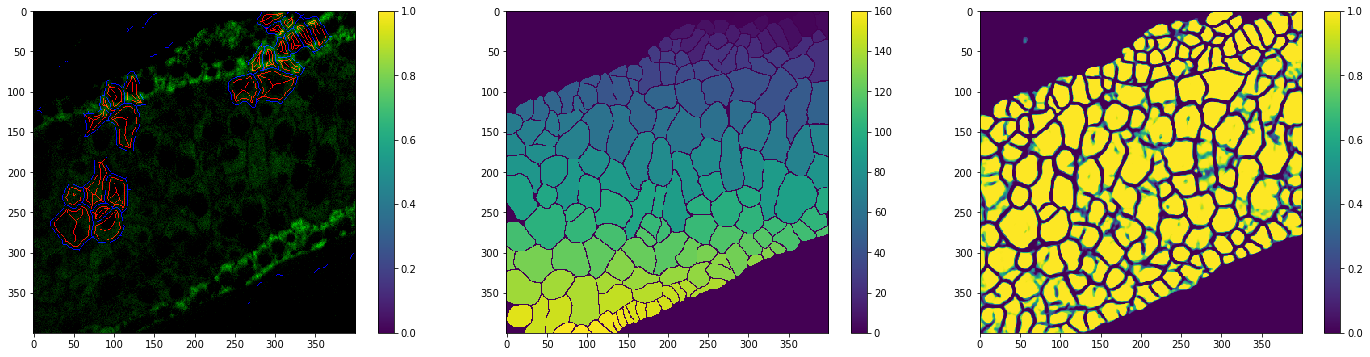

Task :  1


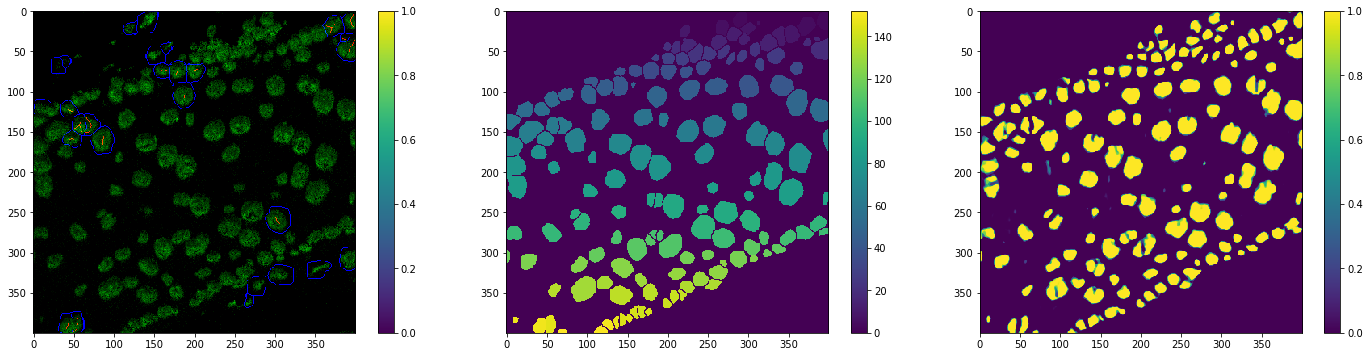

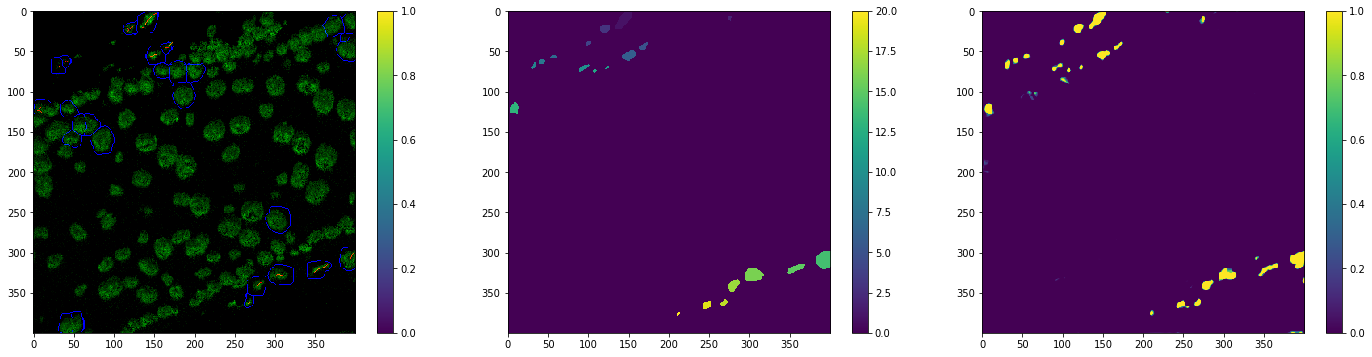

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image1.npz train
Task :  0


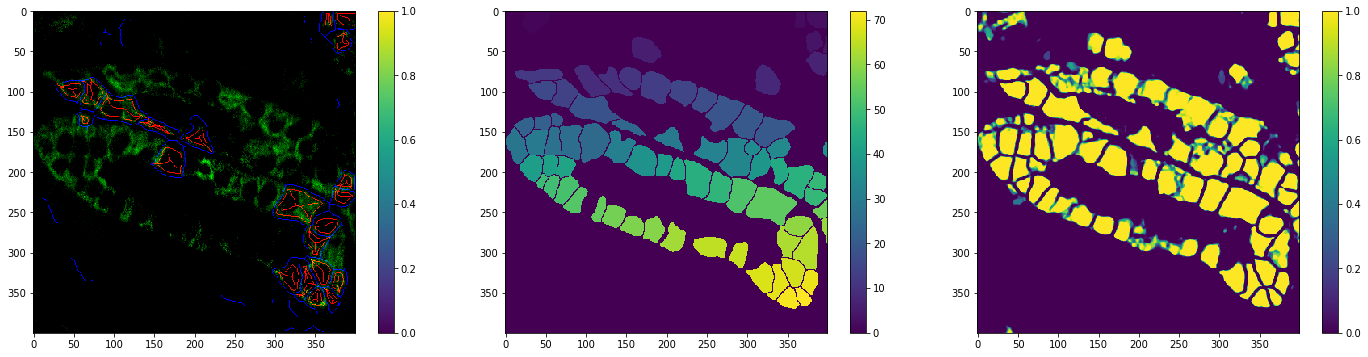

Task :  1


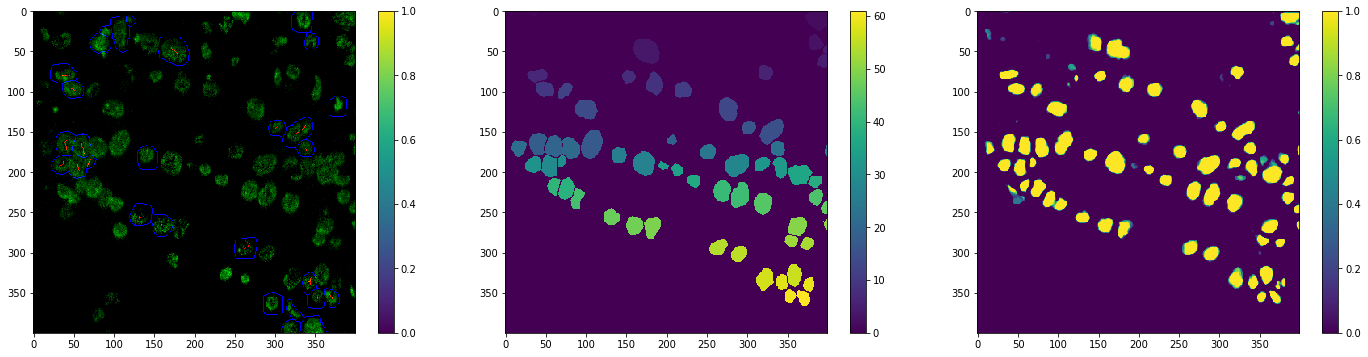

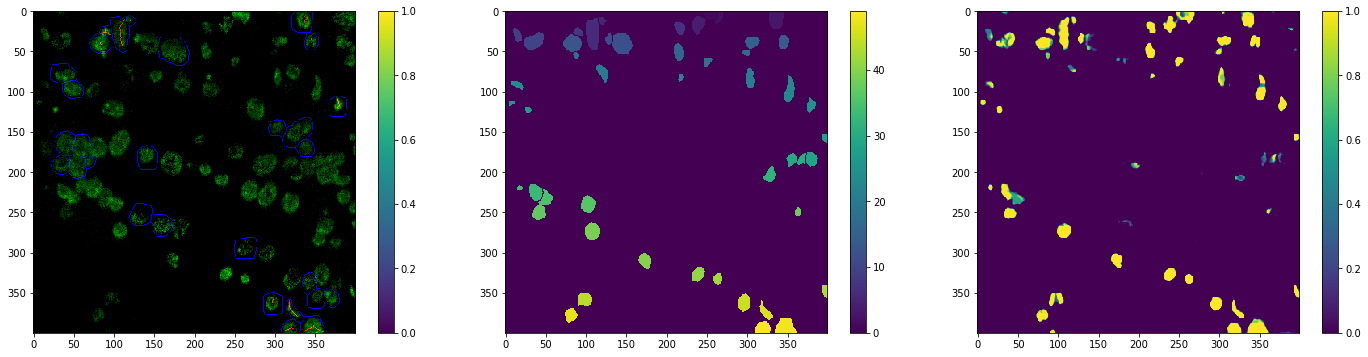


image2.npz test
Task :  0


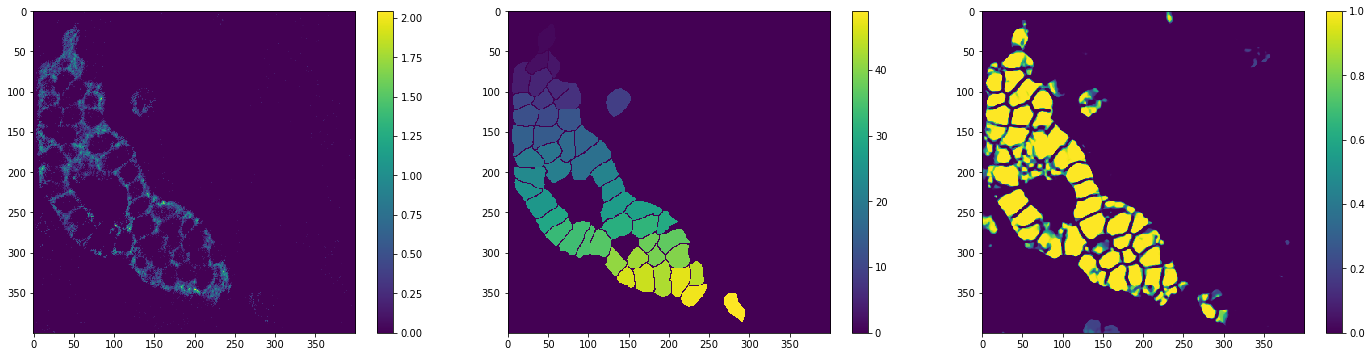

Task :  1


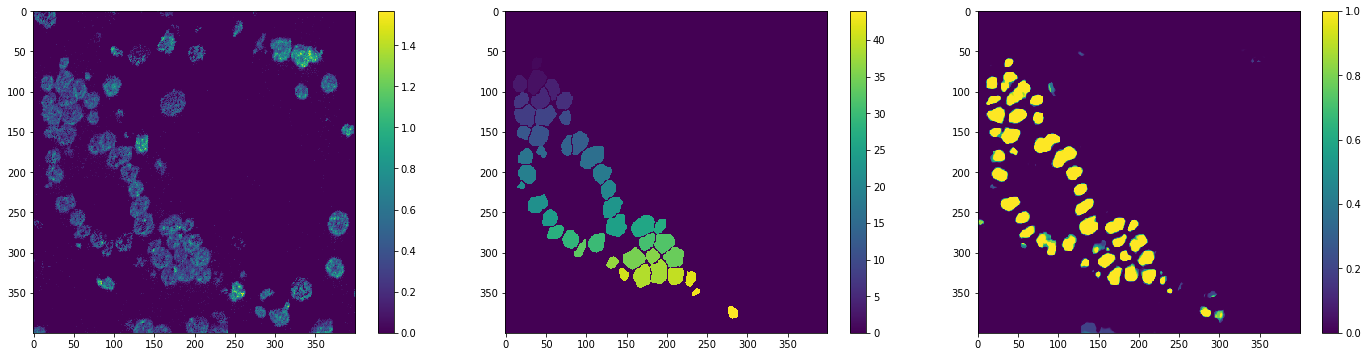

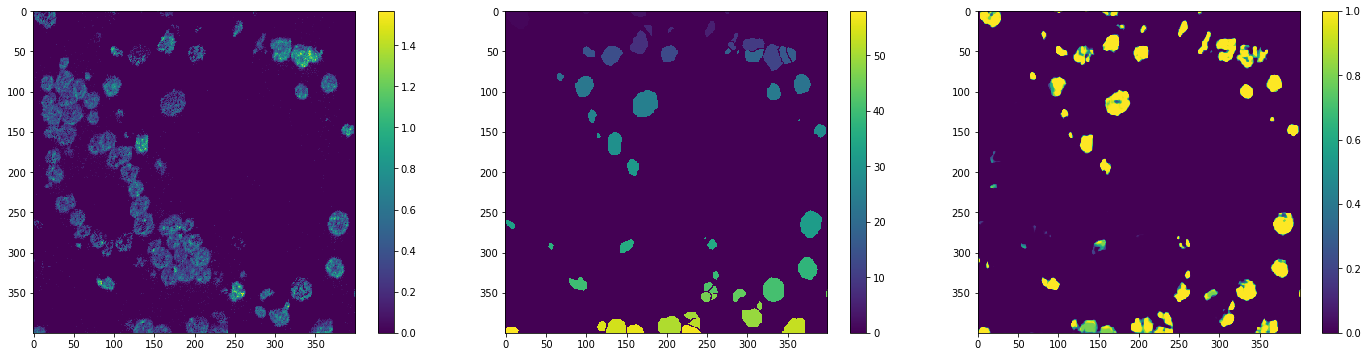

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image3.npz train
Task :  0


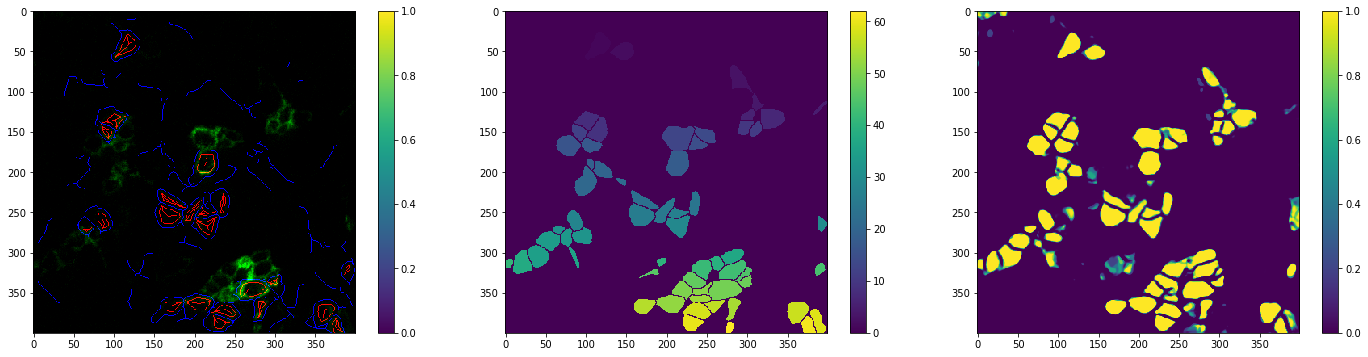

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Task :  1


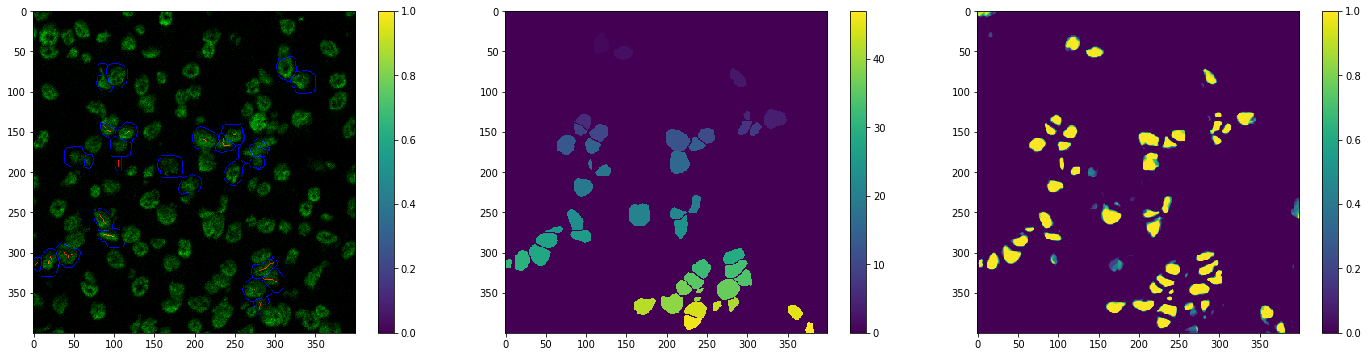

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


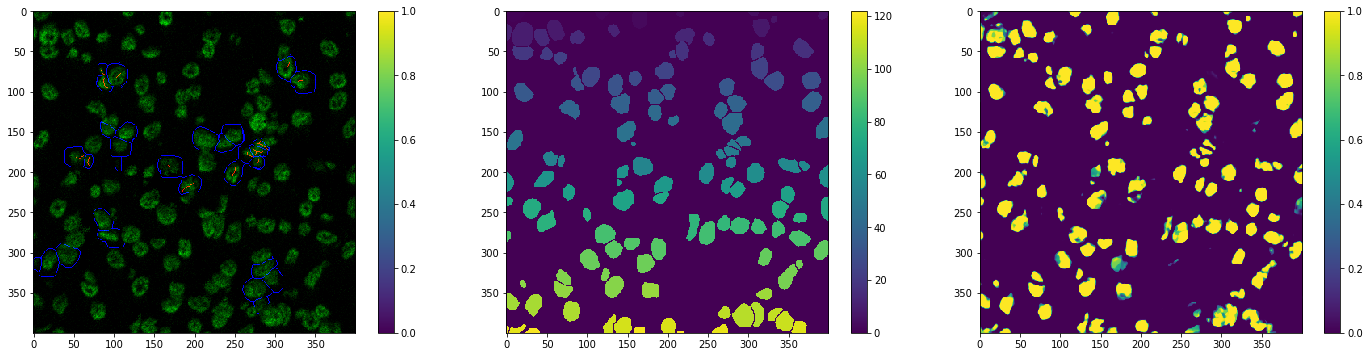

In [10]:
from general.utils import load_json
config_json = load_json(im_model.config.basedir + im_model.config.model_name + '/config.json')

for ix_file in range(len(pd_files)):
    print()
    print(pd_files['input_file'][ix_file],pd_files['group'][ix_file] )
    npz_read = np.load(pd_files['input_dir'][ix_file] + pd_files['input_file'][ix_file])
    image = npz_read['image']
    label = npz_read['label']
    
    output = output_list[ix_file]
    if pd_files['group'][ix_file] == 'train':
        pd_scribble = pd_files_scribbles.loc[pd_files_scribbles['prefix'] == pd_files['prefix'][ix_file]]
        npz_read = np.load(pd_scribble['input_dir'].values[0] + pd_scribble['scribble_file'].values[0])
        scribble = npz_read['scribble']

    ix_scribbles = 0
    for task in output.keys():
        print('Task : ',task)
        
        # get list of corresponding gt indexes to plot
        ix_labels_list = config_json['classification_tasks'][task]['ix_gt_labels']
        rec_channels = config_json['classification_tasks'][task]['rec_channels']
        nclasses = output[task]['class_segmentation'].shape[1]
        for ix_class in range(nclasses):
            
            ix_labels = int(ix_labels_list[ix_class])
            plt.figure(figsize=(20,5))
            plt.subplot(1,3,1)
            
            if pd_files['group'][ix_file] == 'train':
                aux = np.zeros([image.shape[0],image.shape[1],3])
                aux[...,1] = image[...,rec_channels[0]]*0.6
                aux[...,0] = aux[...,0]*(1-scribble[...,ix_scribbles+ix_class]) + scribble[...,ix_scribbles+ix_class]
                aux[...,2] = scribble[...,ix_scribbles+nclasses]
                plt.imshow(aux)
            else:
                plt.imshow(image[...,rec_channels[0]])
            plt.colorbar()

            plt.subplot(1,3,2)
            plt.imshow(label[...,ix_labels])
            ix_labels += 1
            plt.colorbar()

            plt.subplot(1,3,3)
            plt.imshow((output[task]['class_segmentation'][0,ix_class,...]))
            plt.colorbar()

            plt.tight_layout()
            plt.show()
        
        ix_scribbles += nclasses + 1


## Performance

Evaluating average predictions of models : 
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save0.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save1.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save2.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save3.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save4.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save0.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save1.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save2.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save3.pth
/data/natalia/models/Impartial/MIBI2CH_test/model_val_best_save4.pth
Performance evaluation on file  image0
 task :  0 class :  0


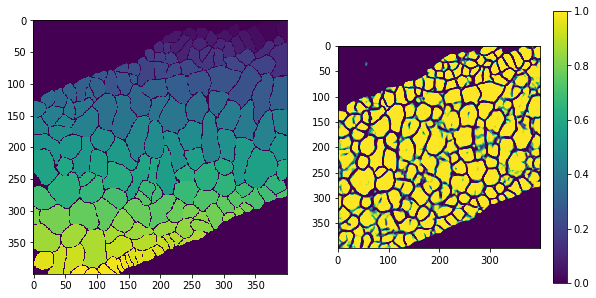

 task :  1 class :  0


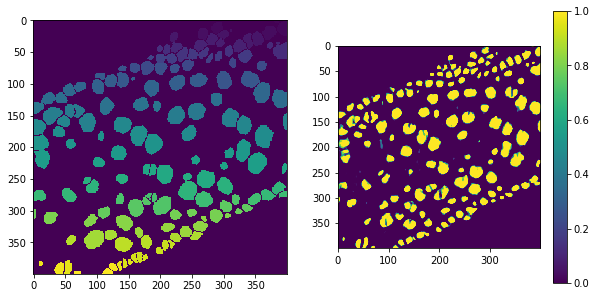

 task :  1 class :  1


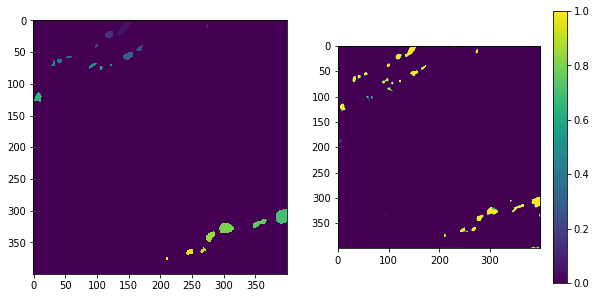

Performance evaluation on file  image1
 task :  0 class :  0


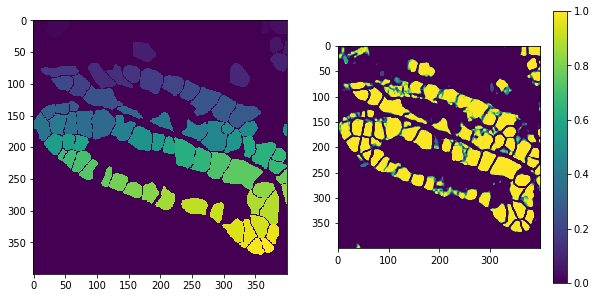

 task :  1 class :  0


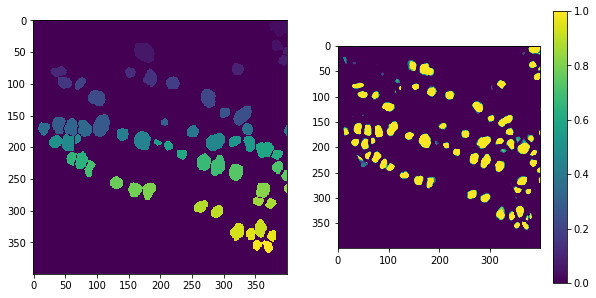

 task :  1 class :  1


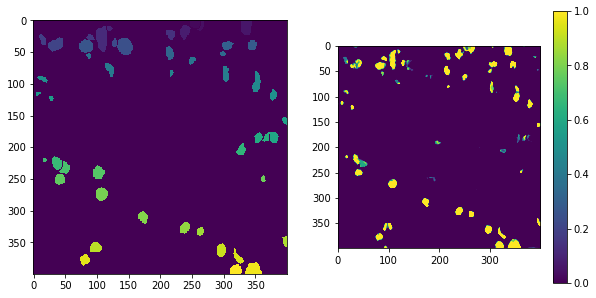

Performance evaluation on file  image2
 task :  0 class :  0


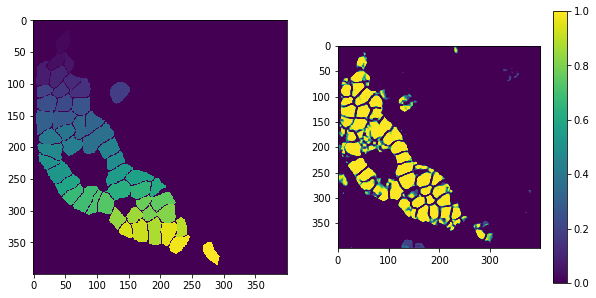

 task :  1 class :  0


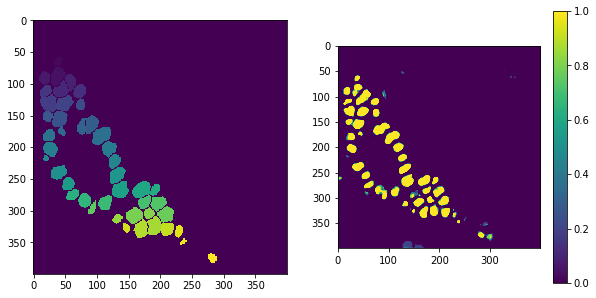

 task :  1 class :  1


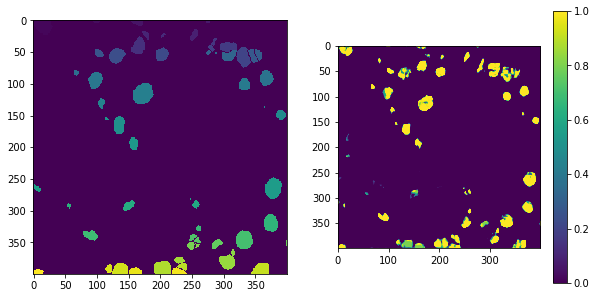

Performance evaluation on file  image3
 task :  0 class :  0


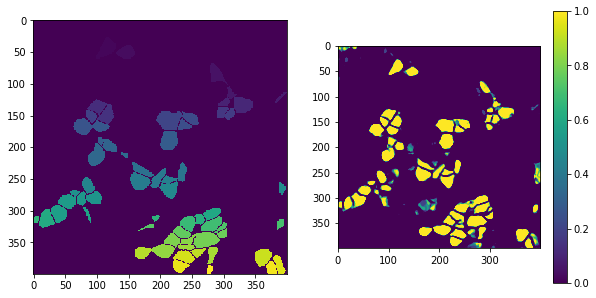

 task :  1 class :  0


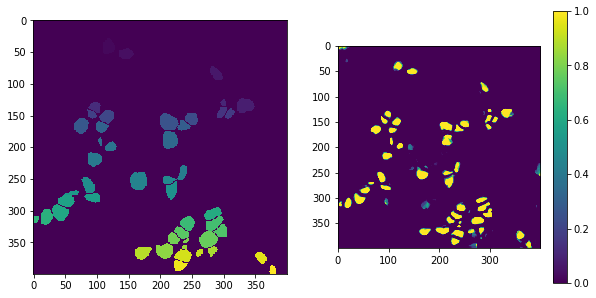

 task :  1 class :  1


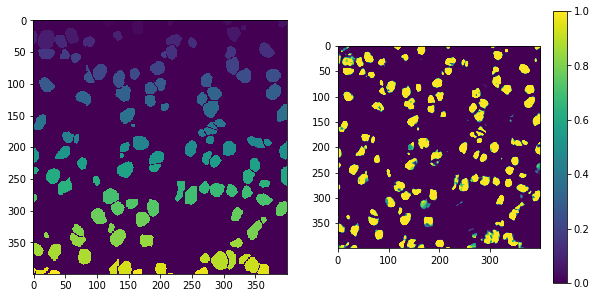

Evaluation csv saved on :  /data/natalia/models/Impartial/MIBI2CH_test/pd_summary_results.csv


In [11]:
pd_summary = im_model.data_performance_evaluation(pd_files,saveout = False, plot = True, 
                                         default_ensembles = True)

pd_summary.to_csv(im_model.config.basedir + im_model.config.model_name + '/pd_summary_results.csv', index=0)
print('Evaluation csv saved on : ', im_model.config.basedir + im_model.config.model_name + '/pd_summary_results.csv')


In [12]:
from general.evaluation import summary_performance

pd_best = summary_performance(pd_summary, best_all = False, metric = 'AP', group = 'train')
pd_best_all = summary_performance(pd_summary, best_all = True)

print('Model selection based on AP on training : ')
print(pd_best.groupby(['task','segclass','group']).mean())
print()
print('Best of all Model selection: ')
print(pd_best_all.groupby(['task','segclass','group']).mean())

Model selection based on AP on training : 
                      th       auc      Jacc      mIoU     mDice        AP
task segclass group                                                       
0    0        test   0.6  0.963171  0.654210  0.509190  0.640986  0.273684
              train  0.6  0.955739  0.703199  0.610710  0.731413  0.442654
1    0        test   0.2  0.929240  0.635605  0.594044  0.731231  0.530303
              train  0.2  0.934474  0.649947  0.643549  0.773548  0.723264
     1        test   0.4  0.982049  0.712391  0.547258  0.667614  0.380952
              train  0.4  0.970997  0.653937  0.634081  0.755171  0.608880

Best of all Model selection: 
                       th       auc      Jacc      mIoU     mDice        AP
task segclass group                                                        
0    0        test   0.95  0.963171  0.725515  0.534354  0.667372  0.290000
              train  0.95  0.955739  0.763184  0.613150  0.734817  0.471451
1    0        test   0